# Augmentation

### Import useful libraries

In [1]:
from typing import Tuple, List
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import kornia as kn
import kornia.augmentation as K

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.models.unet import UNet
from src.training.metrics import dice_loss
from src.training.metrics import evaluate
from src.training.train import train
from src.data.utils import Scan, Patient
from src.data.datasets import ACDCDataset
from src.data.custom_transforms import SimulateTags

### Set up connection to dataset

Raw images and labels (of varying sizes) are saved in `ims` and `las` respectively

In [3]:
acdc_path = Path('../../training')

assert acdc_path.is_dir()

Fetch all images and their labels without any preprocessing or augmentations

In [4]:
verbose: bool = True

# Get all patient folders from main raw downloaded ACDC directory
patient_paths = [ppath for ppath in Path(acdc_path).iterdir() if ppath.is_dir()]

ims: List[np.ndarray] = []
las: List[np.ndarray] = []

accepted_classes: set = set([0., 1., 2., 3.])

# Iterate over all patients
patients_pbar = tqdm(patient_paths, leave=True)
for ppath in patients_pbar:
    if verbose > 0:
        patients_pbar.set_description(f'Processing {ppath.name}...')
    
    # Loading .nii.gz files in handled in the `Patient` class
    patient = Patient(ppath)
    assert len(patient.images) == len(patient.masks)
    
    # Loop through each patient's list of images (around 10 per patient)
    for image, label in zip(patient.images, patient.masks):        
        image, label = image.astype(np.float64), label.astype(np.float64)

        ims.append(image)
        las.append(label)

  0%|          | 0/100 [00:00<?, ?it/s]

### Test out and visualize different augmentations

In [36]:
_preprocess_image = transforms.Compose([
    SimulateTags(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.456, std=0.224),
    transforms.Resize((256, 256))
])

_preprocess_label = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])

In [120]:
selection = slice(0, 10)

images: torch.Tensor = torch.Tensor()
labels: torch.Tensor = torch.Tensor()

for im, la in tqdm(zip(ims[selection], las[selection]), total=len(ims[selection])):

    image = im
    image /= image.max()
    image = _preprocess_image(image).unsqueeze(0)
    image += image.min()
    label = _preprocess_label(la)

    images = torch.cat((images, image), axis=0)
    labels = torch.cat((labels, label), axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [121]:
images.shape, labels.shape

(torch.Size([10, 1, 256, 256]), torch.Size([10, 256, 256]))

In [122]:
augment = K.AugmentationSequential(
    K.RandomHorizontalFlip(),
    K.RandomVerticalFlip(),
    K.RandomElasticTransform(),
    K.RandomGaussianNoise(),
    K.RandomSharpness(),
    K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(.1, .1)),
    data_keys=['input', 'mask']
)

In [133]:
str(augment)

'AugmentationSequential(\n  (RandomHorizontalFlip_0): RandomHorizontalFlip(RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False), return_transform=None)\n  (RandomVerticalFlip_1): RandomVerticalFlip(RandomVerticalFlip(p=0.5, p_batch=1.0, same_on_batch=False), return_transform=None)\n  (RandomElasticTransform_2): RandomElasticTransform(RandomElasticTransform(p=0.5, p_batch=1.0, same_on_batch=False, kernel_size=(63, 63), sigma=(32.0, 32.0), alpha=(1.0, 1.0), align_corners=False, mode=bilinear, padding_mode=zeros), return_transform=False)\n  (RandomGaussianNoise_3): RandomGaussianNoise(RandomGaussianNoise(p=0.5, p_batch=1.0, same_on_batch=False, mean=0.0, std=1.0), return_transform=False)\n  (RandomSharpness_4): RandomSharpness(RandomSharpness(sharpness=0.5, p=0.5, p_batch=1.0, same_on_batch=False), return_transform=False)\n  (RandomGaussianBlur_5): RandomGaussianBlur(RandomGaussianBlur(p=0.5, p_batch=1.0, same_on_batch=False, kernel_size=(3, 3), sigma=(0.1, 0.1), border_type=refl

In [124]:
aug_ims, aug_las = augment(images, labels.unsqueeze(1))

In [138]:
aug_las.squeeze(1).size()

torch.Size([10, 256, 256])

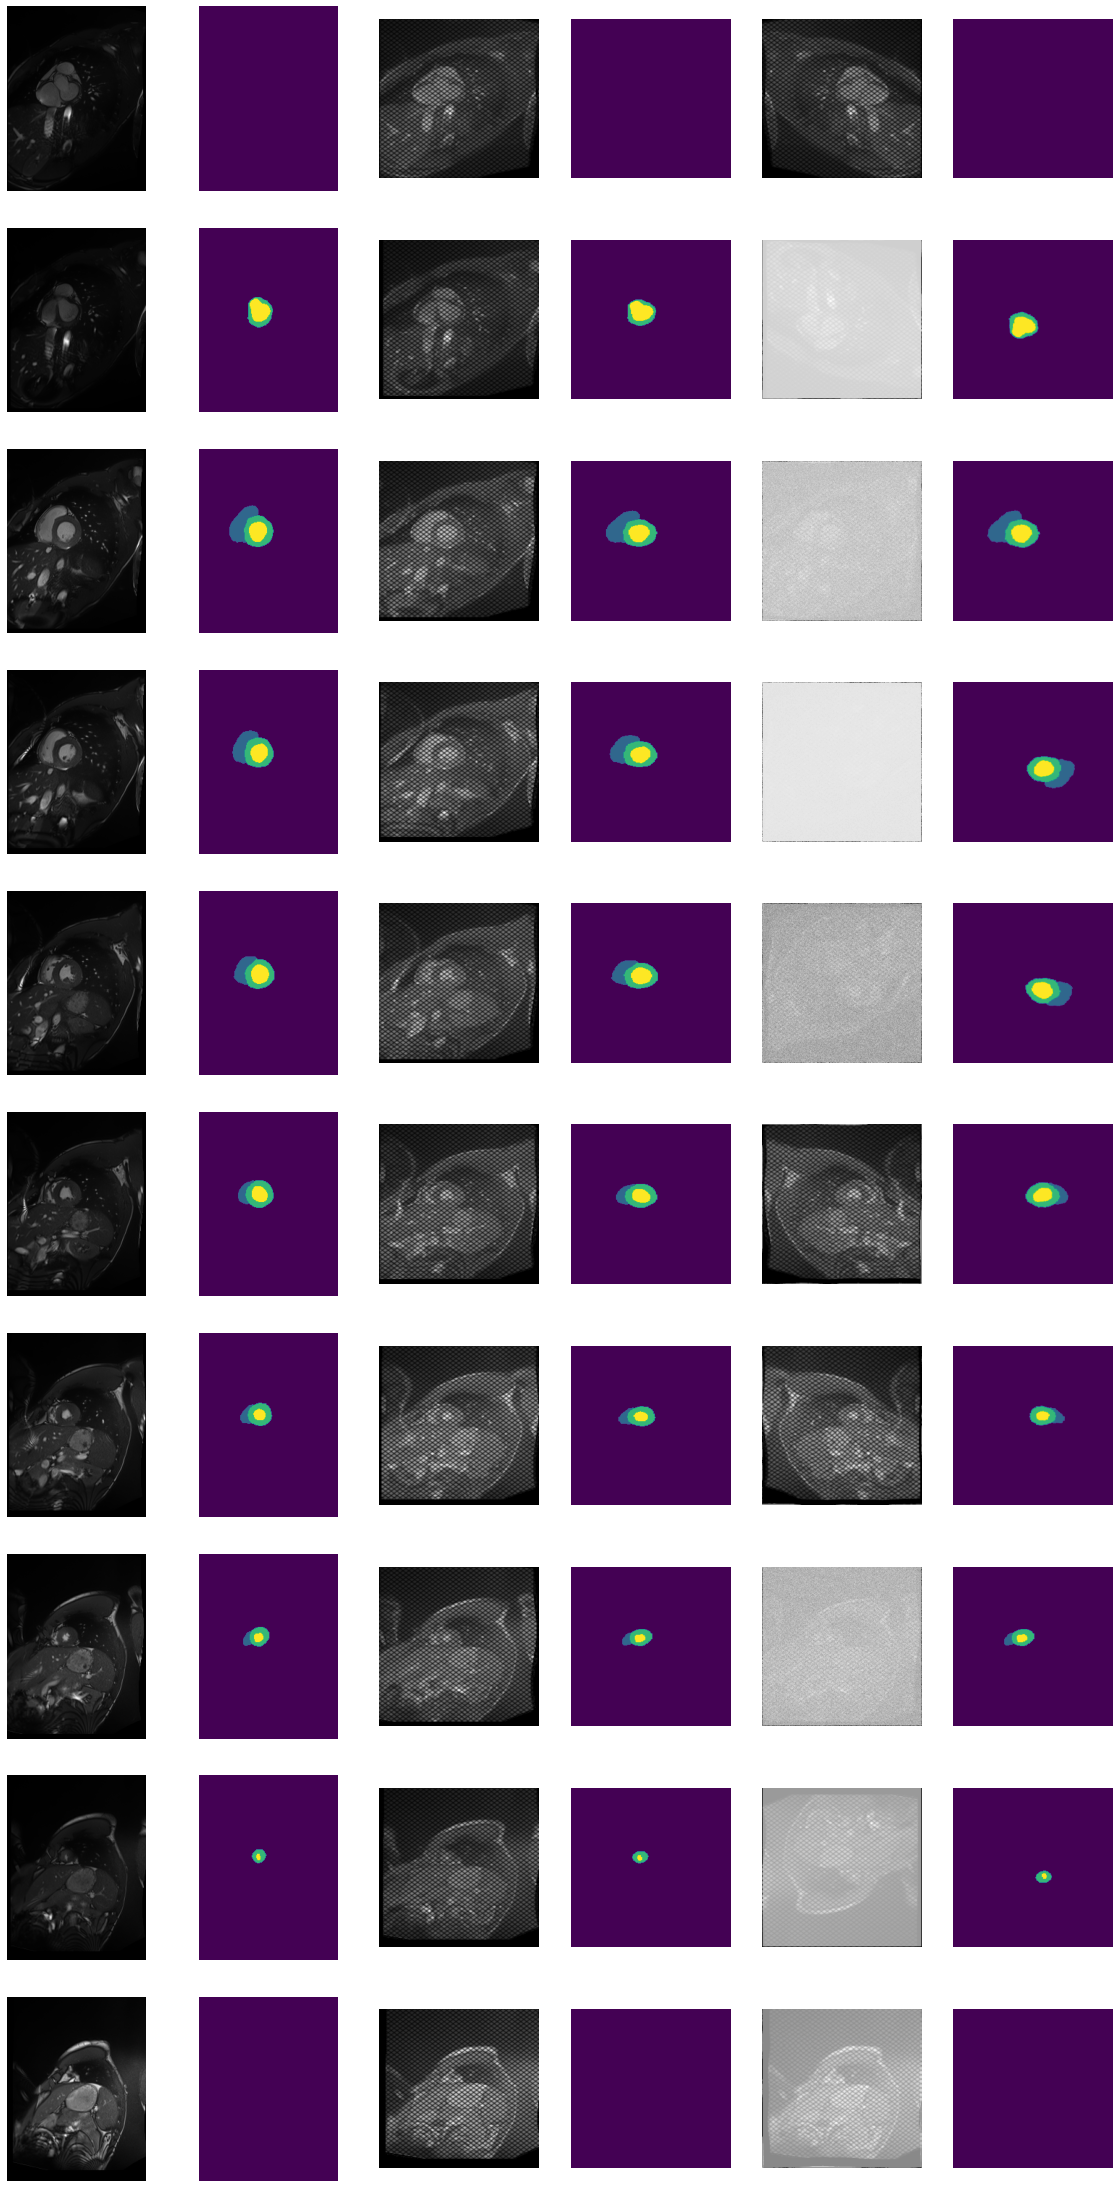

In [126]:
fig, axes = plt.subplots(10, 6, figsize=(20, 40))

for i in range(10):
    axes[i, 0].imshow(ims[i], cmap='gray'),         axes[i, 0].axis('off')
    axes[i, 1].imshow(las[i]),                      axes[i, 1].axis('off')
    axes[i, 2].imshow(images[i, 0], cmap='gray'),   axes[i, 2].axis('off')
    axes[i, 3].imshow(labels[i]),                   axes[i, 3].axis('off')
    axes[i, 4].imshow(aug_ims[i, 0], cmap='gray'),  axes[i, 4].axis('off')
    axes[i, 5].imshow(aug_las[i, 0]),               axes[i, 5].axis('off')